In [632]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Read in and do Further Cleaning

In [633]:
# Let's get some data
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')

train.drop(columns=['Unnamed: 0', 'Id'], inplace=True)
test.drop(columns=['Unnamed: 0', 'Id'], inplace=True)

## Investigation of Trends

### Neighborhood v Sale Price

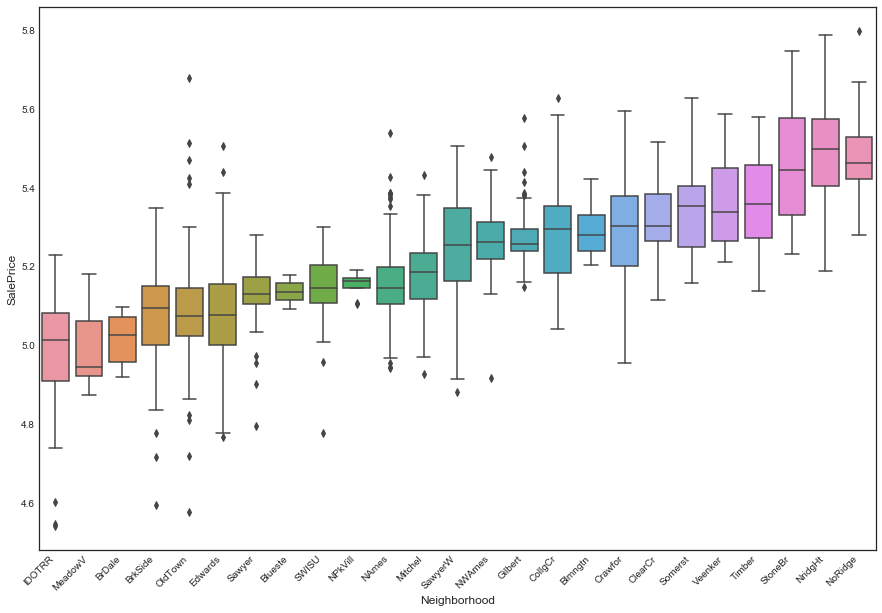

In [634]:
# Find the order
my_order = train.groupby(by=["Neighborhood"])["logPrice"].mean().sort_values().index
 
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="Neighborhood", y=np.log10(train['SalePrice']), data=train, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

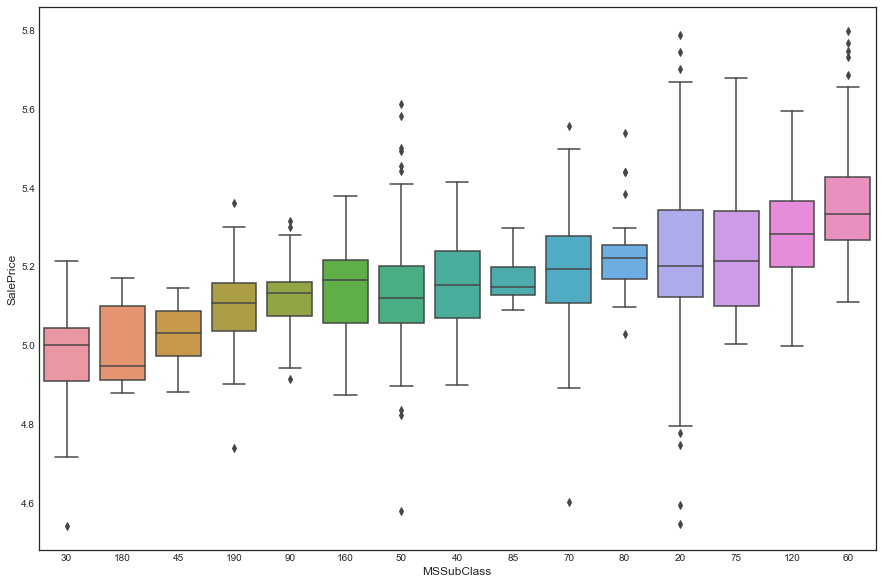

In [635]:
# Find the order
my_order = train.groupby(by=["MSSubClass"])["logPrice"].mean().sort_values().index
 
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="MSSubClass", y=np.log10(train['SalePrice']), data=train, order=my_order)

It's clear location matters in the price of the home. While there are outliers, the sale price of a home can be roughly correlated with where it is in Ames. This led me to create a new feature called PriceRange that I would be able to segment a model by. 

### Capturing Location and Subjective Effects on Price

[Text(0, 0.5, 'Sale Price'), Text(0.5, 0, 'Overall Quality')]

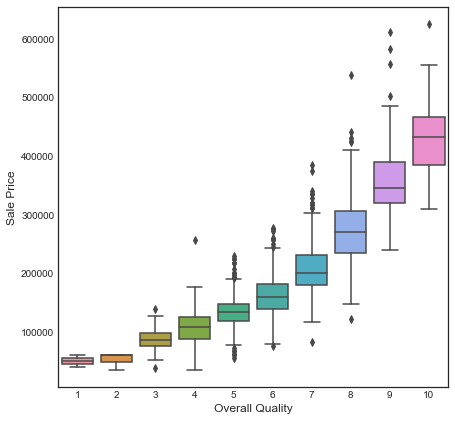

In [636]:
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="OverallQual", y='SalePrice', data=train)
ax.set(xlabel='Overall Quality', ylabel='Sale Price')

#ax.figure.savefig("./presentation/qualbox_v_sale.svg",bbox_inches='tight')

Overall Quality has a strongly monotonically increasing (some would say exponential) relationship with SalePrice - a prime candidate!

[Text(0, 0.5, 'Sale Price'), Text(0.5, 0, 'Zoning')]

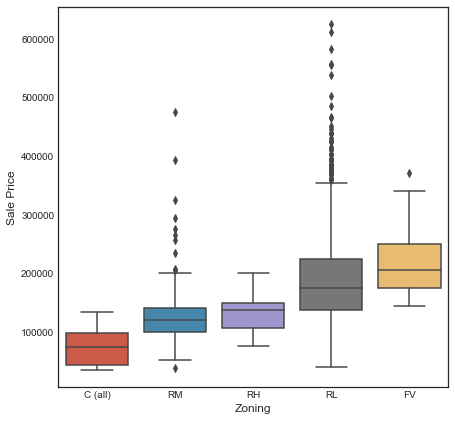

In [637]:
# Order by mean sale price
my_order = train.groupby(by=["MSZoning"])["SalePrice"].mean().sort_values().index

plt.figure(figsize=(7,7))
ax = sns.boxplot(x="MSZoning", y='SalePrice', data=train, order=my_order)
ax.set(xlabel='Zoning', ylabel='Sale Price')

#ax.figure.savefig("./presentation/zonebox_v_sale.svg",bbox_inches='tight')

Zoning also has a montonically increasing relationship with SalePrice. A good candidate for our following operation. 

#### Feature Engineering: PriceRange

In [638]:
hood_means = train.groupby(by=["Neighborhood",'MSZoning','OverallQual'])["logPrice"].mean().reset_index()
hood_means['PriceRange'] = pd.qcut(hood_means.logPrice,3,labels=['Low','Middle','High'])
hood_means.head(10)

,Neighborhood,MSZoning,OverallQual,logPrice,PriceRange
0,Blmngtn,RL,7,12.142839,Middle
1,Blmngtn,RL,8,12.309824,High
2,Blmngtn,RM,7,12.093688,Middle
3,Blueste,RM,6,11.826536,Middle
4,BrDale,RM,5,11.668091,Low
5,BrDale,RM,6,11.493216,Low
6,BrkSide,RL,1,10.578980,Low
7,BrkSide,RL,3,11.098462,Low
8,BrkSide,RL,4,11.492390,Low
9,BrkSide,RL,5,11.826213,Middle


In [639]:
train = train.merge(hood_means[['Neighborhood','PriceRange','MSZoning','OverallQual']], on = ['Neighborhood','MSZoning','OverallQual'])
test = test.merge(hood_means[['Neighborhood','PriceRange','MSZoning','OverallQual']], on = ['Neighborhood','MSZoning','OverallQual'], how='left')

In [640]:
train[['Neighborhood','MSZoning','OverallQual','SalePrice','PriceRange']].sample(10)

,Neighborhood,MSZoning,OverallQual,SalePrice,PriceRange
1011,SawyerW,RL,7,205000,High
86,Crawfor,RL,7,335000,High
758,Gilbert,RL,7,176485,High
10,CollgCr,RL,7,204000,High
546,CollgCr,RL,5,127000,Low
4,CollgCr,RL,7,219500,High
44,CollgCr,RL,7,192500,High
113,Mitchel,RL,5,124500,Low
1164,StoneBr,RL,7,260000,High
94,NoRidge,RL,8,315000,High


#### Impute Missing Values

In [641]:
test[test['PriceRange'].isnull()][['Neighborhood','MSZoning','OverallQual','PriceRange']]

,Neighborhood,MSZoning,OverallQual,PriceRange
0,NAmes,RH,5,NaN
14,NPkVill,RL,7,NaN
76,OldTown,RM,2,NaN
98,SWISU,C (all),4,NaN
133,SWISU,RH,4,NaN
138,Blueste,RM,8,NaN
139,Blueste,RM,8,NaN
140,IDOTRR,RM,2,NaN
194,NPkVill,RL,7,NaN
198,NPkVill,RL,7,NaN


In [642]:
test['PriceRange'] = test.PriceRange.fillna('Middle')

This was a big issue. The test set is larger than the actual train set. This create problems when trying to do non trivial feature engineering in that as the curse of dimensionality starts to play a role in how well the test set populates the bins we created. 

Adding more features (or even features better correlated with SalePrice than MSZoning like MSSubClass) would have given a cleaner separability as we shall see below. But this was a compromise we had to make to minimize imputation and make the feature sufficiently flexible to capture the unknown price range of the test data.

### Data Separability

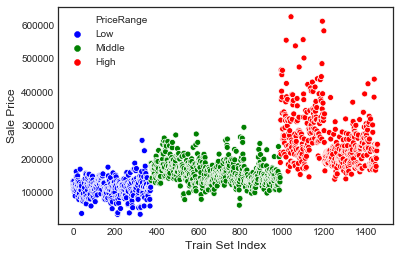

In [643]:
# Sort Values for nice display
train.sort_values('PriceRange', inplace=True)
train.reset_index(drop=True, inplace=True)
ax = sns.scatterplot(x=range(len(train)), y = 'SalePrice', 
                     hue='PriceRange', 
                     palette=['Blue','Green','Red'],
                     data=train)

ax.set(xlabel='Train Set Index', ylabel='Sale Price');
#ax.figure.savefig("./presentation/price_range.svg",bbox_inches='tight')

Medians

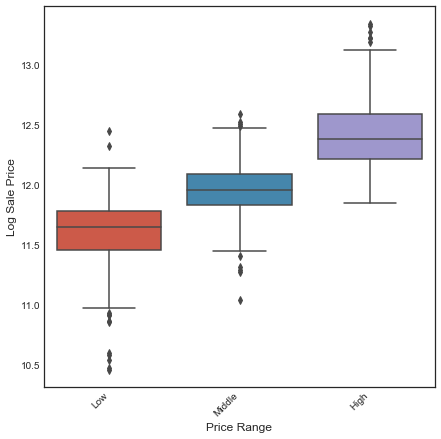

In [644]:
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="PriceRange", y='logPrice', data=train)#, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set(xlabel='Price Range', ylabel='Log Sale Price');
#ax.figure.savefig("./presentation/price_range_box.svg",bbox_inches='tight')

### Feature Interactions across PriceRange

#### Overall Quality of Home

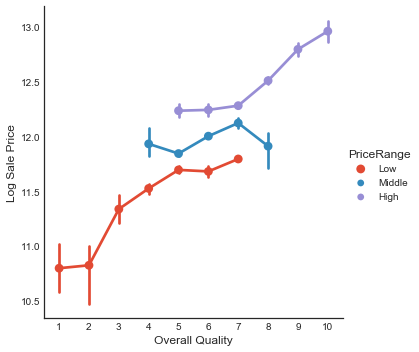

In [645]:
ax = sns.catplot(x="OverallQual", y="logPrice", hue="PriceRange", kind="point", data=train);

ax.set(xlabel='Overall Quality', ylabel='Log Sale Price')
ax.savefig("./presentation/seaborn/qual_v_logsale.svg",bbox_inches='tight')

Evidently nonlinear behaviour is hiding within linearity across these classes

#### Overall Condition of Home

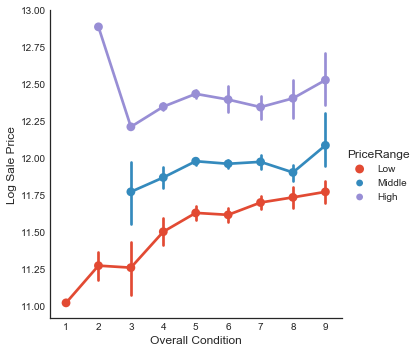

In [646]:
ax = sns.catplot(x="OverallCond", y="logPrice", hue="PriceRange", kind="point", data=train);
ax.set(xlabel='Overall Condition', ylabel='Log Sale Price')
#ax.savefig("./presentation/seaborn/cond_v_sale.svg",bbox_inches='tight')

Strange behavior with High end homes in horrible overall condition, feature has different linear and nonlinear behavior across Price classes

### Transforming the Response to be more Normal!

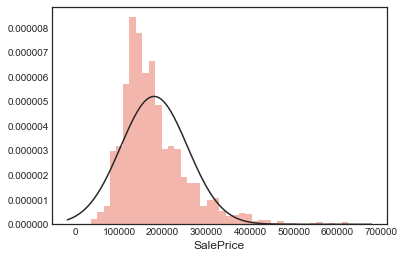

In [647]:
from scipy.stats import norm
ax = sns.distplot(a=train.SalePrice, fit=norm, kde=False);
#ax.figure.savefig("./presentation/seaborn/hist_saleprice.svg",bbox_inches='tight')

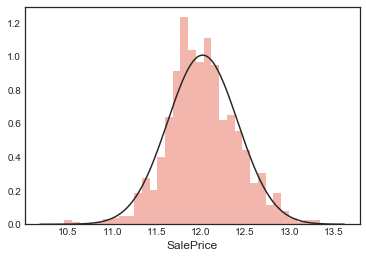

In [648]:
ax = sns.distplot(a=np.log(train.SalePrice), fit=norm, kde=False);
#ax.figure.savefig("./presentation/seaborn/hist_logprice.svg",bbox_inches='tight')

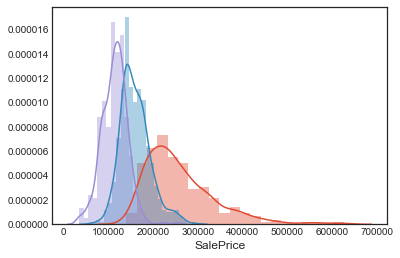

In [649]:
ax = sns.distplot(train[train.PriceRange == 'High']['SalePrice'])
sns.distplot(train[train.PriceRange == 'Middle']['SalePrice'])
sns.distplot(train[train.PriceRange == 'Low']['SalePrice']);
#ax.figure.savefig("./presentation/seaborn/hist_price_range.svg",bbox_inches='tight')

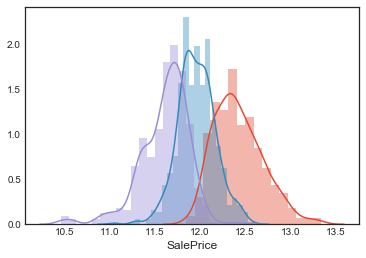

In [650]:

ax = sns.distplot(np.log(train[train.PriceRange == 'High']['SalePrice']))
sns.distplot(np.log(train[train.PriceRange == 'Middle']['SalePrice']))
sns.distplot(np.log(train[train.PriceRange == 'Low']['SalePrice']));


ax.figure.savefig("./presentation/seaborn/log_hist_price_range.svg",bbox_inches='tight')

These separated Gaussian-like PriceClasses are very suggestive for an LDA type model... maybe in the future.

## Modeling GAMs (all the modeling work done in R)

### Motivation

<img src="./presentation/three-lm-problems-1.png">

Three assumptions of the linear model (left side):
- Gaussian distribution of the outcome given the features
- Additivity (no interactions)
- Linear relationship between predictors and response. 

Reality usually does not adhere to those assumptions (right side): 

- Outcomes might have non-Gaussian distributions
- Features might interact
- Relationship might be nonlinear.

Main difference between linear and GAM models are that linear models assume a fixed linear or some other parametric form of the relationship between the dependent variable and the covariates. A GAM makes no such assumptions a priori of any specific form of this relationship, and - in fact - can be used to reveal and estimate non-linear effects of the covariate on the dependent variable. 

In linear models the linear predictor is a weighted sum of $n$ covariates.
In a GAM this term is replaced by a sum of smooth functions. 

By combining basis functions GAMs can represent a large number of functional relationship (to do so they rely on the assumption that the true relationship is likely to be smooth, rather than wiggly). 

Essentially an extension of GLMs, they are designed in a way that makes them particularly useful for uncovering nonlinear effects of numerical covariates, and for doing so in an "automatic" fashion [Hastie and Tibshirani original article], they have 'the advantage of being completely automatic, i.e. no "detective" work is needed on the part of the statistician.

## Generalized Cross Validation

Provides a convenient approximation to leave one out CV for linear fitting under a squared error loss. S is the hat matrix

$$GCV(\hat{f}) = \frac{1}{N}\sum_{i=1} \left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$$

In smoothing problems, GCV can also alleviate tendency of cross validation to undersmooth. Has similarity to AIC from the approximation 

$$1/(1-x)^2 \approx 1+2x$$

GCV is used for smoothness selection in the mgcv package in R. Smoothing parameters are chosen to minimize prediction error. GCV is preferred over CV since there's no need to refit the model onto subsets of the data. It functions like the AIC, in that smaller values indicate better fitting models. 

GAMs fitted using GCV smoothness selection can suffer from under-smoothing. 
